In [181]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
from tqdm import tqdm
rcParams['figure.figsize'] = 15, 15

### Plot Functions

In [182]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[2,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[2,:], color='orangered', label=label_2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax

In [183]:
def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()

In [184]:
def draw_correspondences(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not label_added:
            ax.plot(x, y, zs=z, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, zs=z, color='grey')
    ax.legend()

### Random Rotation and Translation

In [185]:
theta = math.pi / 3
c, s = np.cos(theta), np.sin(theta)

S = 3 * np.identity(3)

R_act = np.array(
                    [[c, -s, 0],[s, c, 0], [0, 0, 1]]
                )
t_act = np.array([[-5],[6], [7]])

### Mean Centering

In [186]:
def mean_center(S, exclude_indices=[]):
    reduced_data = np.delete(S, exclude_indices, axis=1)
    center = np.array(reduced_data.mean(axis=1)).T
    return center, S - center.reshape(3,1)

### Cross Covariance Matrix

In [187]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((3, 3))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

### Kd tree correspondences

In [188]:
from sklearn.neighbors import KDTree

def kd_tree_correspondences(point_set_p, point_set_q):
    tree = KDTree(point_set_q.T)
    dist, ind = tree.query(point_set_p.T)
    correspondences = [(i, ind[i][0]) for i in range(point_set_p.T.shape[0])]
    return correspondences

### ICP scale Invariant

In [189]:
def find_alignment(P, Q, correspondences):
    dim_p, p_size = P.shape
    dim_q, q_size = Q.shape
    
    Y = np.zeros((3, p_size))
    
    for i in range(p_size):
        Y[:, i] = Q[:, correspondences[i][1]]
    
    mean_p, mean_y = np.mean(P, axis=1), np.mean(Y, axis=1)
    
    _mean_centerd_p, _mean_centerd_y = P - mean_p.reshape(3,1), Y - mean_y.reshape(3, 1)
    
    
    Px, Py, Pz = _mean_centerd_p[0, :], _mean_centerd_p[1, :], _mean_centerd_p[2, :]
    Yx, Yy, Yz = _mean_centerd_y[0, :], _mean_centerd_y[1, :], _mean_centerd_y[2, :]
    
    Sxx, Sxy, Sxz = Px.dot(Yx), Px.dot(Yy), Px.dot(Yz)
    Syx, Syy, Syz = Py.dot(Yx), Py.dot(Yy), Py.dot(Yz)
    Szx, Szy, Szz = Pz.dot(Yx), Pz.dot(Yy), Pz.dot(Yz)

    N_matrix = np.array([
        [Sxx + Syy + Szz, Syz - Szy, Szx - Sxz, Sxy - Syx],
        [Syz - Szy, Sxx - Szz - Syy, Sxy + Syx, Sxz + Szx],
        [Szx - Sxz, Syx + Sxy, Syy - Sxx - Szz, Syz + Szy],
        [Sxy - Syx, Szx + Sxz, Szy + Syz, Szz - Syy - Sxx]
    ])
    
    L, V = np.linalg.eig(N_matrix)
    
    max_l = np.where(L == np.amax(L))[0][0]
    
    q = V[:, max_l] ##min eigen vector
    
    q0, q1, q2, q3 = q[0], q[1], q[2], q[3]
    
    Q_bar = np.array([
        [q0, -q1, -q2, -q3],
        [q1, q0, q3, -q2],
        [q2, -q3, q0, q1],
        [q3, q2, -q1, q0]
    ])
    
    Q = np.array([
        [q0, -q1, -q2, -q3],
        [q1, q0, -q3, q2],
        [q2, q3, q0, -q1],
        [q3, -q2, q1, q0]
    ])
    
    R = Q_bar.T.dot(Q)
    
    R = R[1:4, 1:4]
    
    Sp, D = 0, 0
    
    for i in range(p_size):
        D += _mean_centerd_y[:, i].T.dot(_mean_centerd_y[:, i])
        Sp += _mean_centerd_p[:, i].T.dot(_mean_centerd_p[:, i])
    
    
    s = math.sqrt(D / Sp)
    
    t = mean_y.reshape(3, 1) - s * R.dot(mean_p.reshape(3, 1))
    
    err = 0
    for i in range(p_size):
        d = Y[:, i].reshape(3,1) - s * R.dot(P[:, i].reshape(3,1)) - t
        err += d.T.dot(d)
    
    return s, R, t, err



def icp_scale_invarant(M, P, iterations=10, kernel=lambda diff: 1.0):
    s = None
    R = None
    t = None
    new_p = P.copy()
    
    p_size, m_size = P.shape[1], M.shape[1]
    dim = P.shape[0]
    
    err_list = []    
    
    for itr in tqdm( range(iterations), desc ="Iteration"):
        correspondences = kd_tree_correspondences(new_p, M)
        s, R, t, err = find_alignment(new_p, M, correspondences)
        S = s * np.identity(3)
        
        new_p = S.dot(R.dot(new_p)) + t.reshape(3,1)
        
        for corr in correspondences:
            err += np.linalg.norm(new_p[:, corr[0]] - M[:, corr[1]])**2
        
        err = err/p_size
        err_list.append(err)
        
        if err < 1e-5:#threshold
            break

    return new_p, err_list
            
        

In [190]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = mean_center(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in tqdm( range(iterations), desc ="Iteration"):
        center_of_P, P_centered = mean_center(P_copy, exclude_indices=exclude_indices)
        correspondences = kd_tree_correspondences(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)
        t = center_of_Q - R.dot(center_of_P)
        P_copy = R.dot(P_copy) + t.reshape(3, 1)
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

### Random Point set generation P, Q

### 100 points

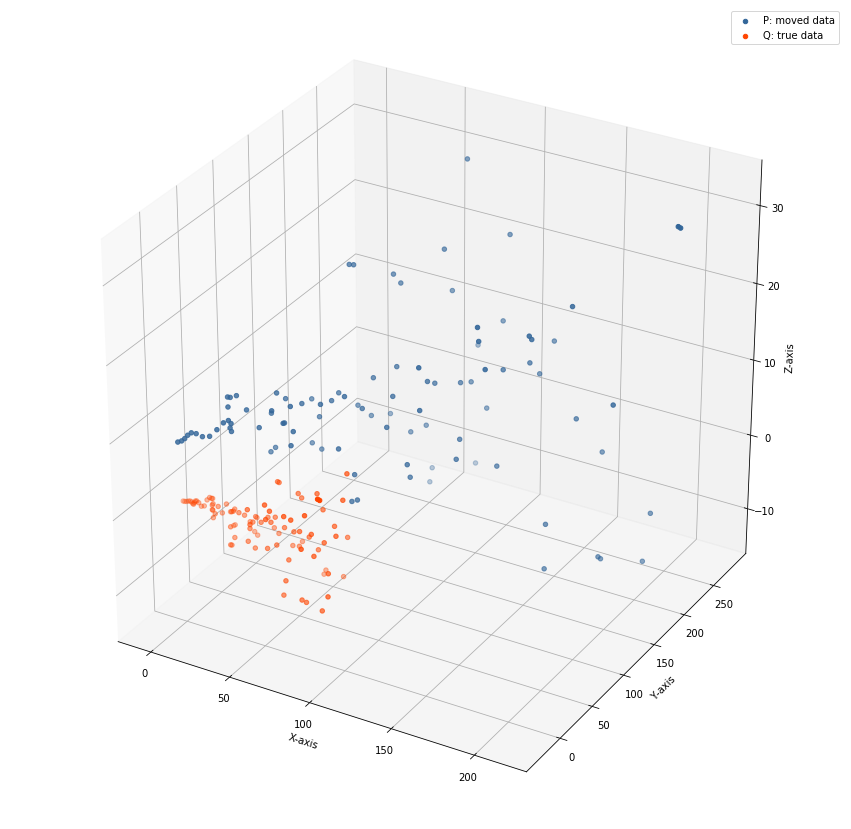

In [191]:
num_points = 100
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = S.dot(R_act.dot(Q)) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Cetering

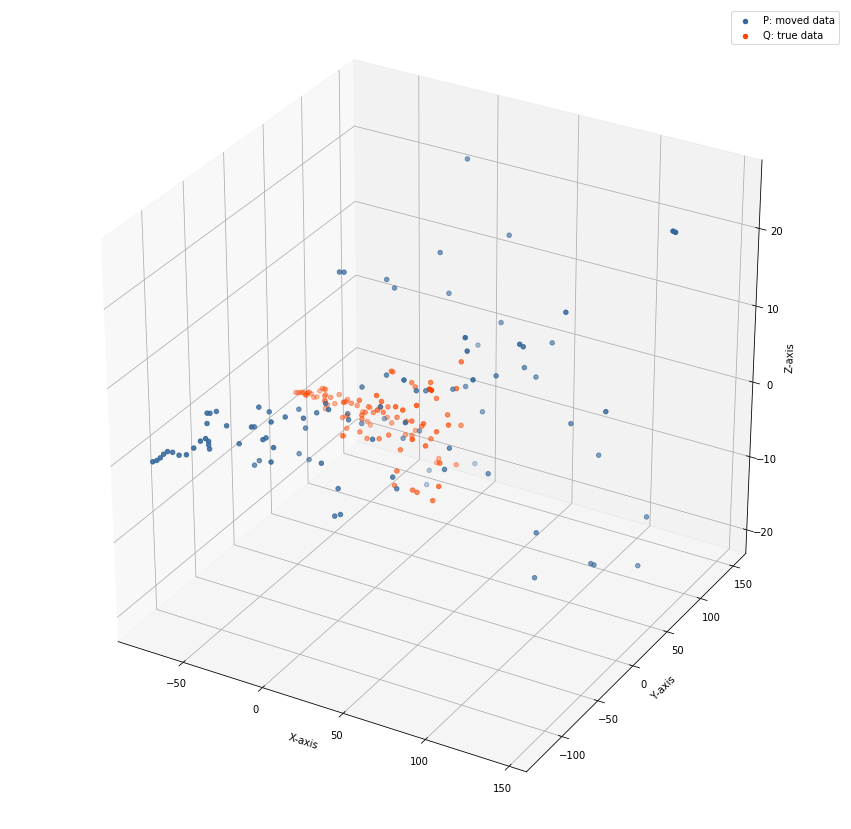

In [192]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### Compute Correspondences

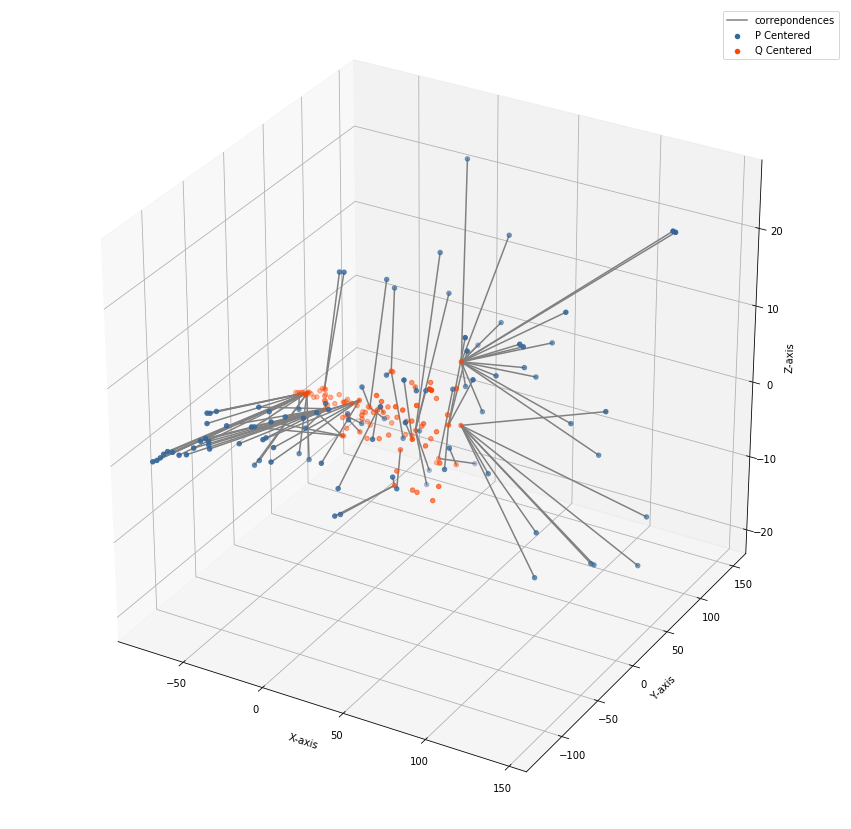

In [193]:
correspondences = kd_tree_correspondences(mean_centered_P, mean_centered_Q)
ax = plot_data(mean_centered_P, mean_centered_Q, label_1='P Centered', label_2='Q Centered')
draw_correspondences(mean_centered_P, mean_centered_Q, correspondences, ax)
plt.show()

#### ICP

Iteration: 100%|██████████| 100/100 [00:00<00:00, 812.83it/s]


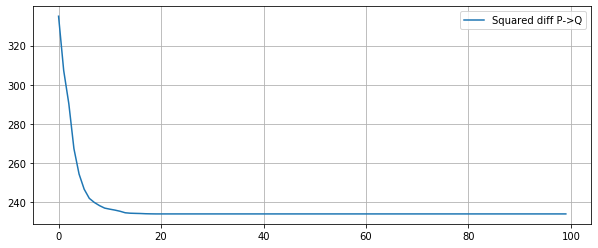

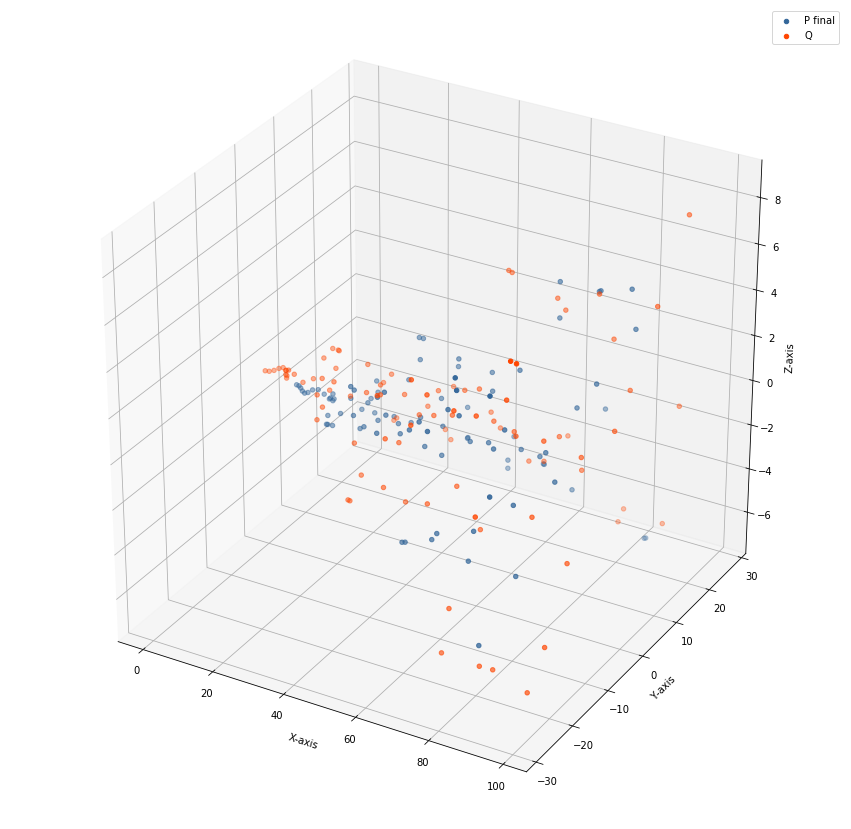

[334.9316609587205, 307.2727821568122, 290.3575743464155, 267.38311875469634, 254.45795435385327, 246.72221594789798, 242.05736627372025, 239.9366438980477, 238.34392710614412, 237.0853482681735, 236.55174954590314, 236.06929814167276, 235.4831660376594, 234.71453427385785, 234.48606555338625, 234.40105863124924, 234.33238482813988, 234.21634024932706, 234.16417418426283, 234.12625617523824, 234.1262561752382, 234.12625617523813, 234.1262561752381, 234.12625617523807, 234.1262561752381, 234.12625617523804, 234.126256175238, 234.12625617523798, 234.1262561752379, 234.1262561752379, 234.1262561752379, 234.1262561752378, 234.12625617523776, 234.12625617523773, 234.1262561752377, 234.12625617523767, 234.12625617523764, 234.1262561752376, 234.12625617523756, 234.12625617523747, 234.12625617523747, 234.12625617523742, 234.12625617523736, 234.1262561752374, 234.12625617523736, 234.12625617523736, 234.1262561752373, 234.1262561752373, 234.12625617523733, 234.1262561752373, 234.12625617523724, 

In [194]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=100)
# ax = plot_data(P_values, Q, label_1='P final', label_2='Q', markersize_1=15)
p_values , n, c = icp_svd(P_values, Q, iterations=100)
plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)

### 10000 points

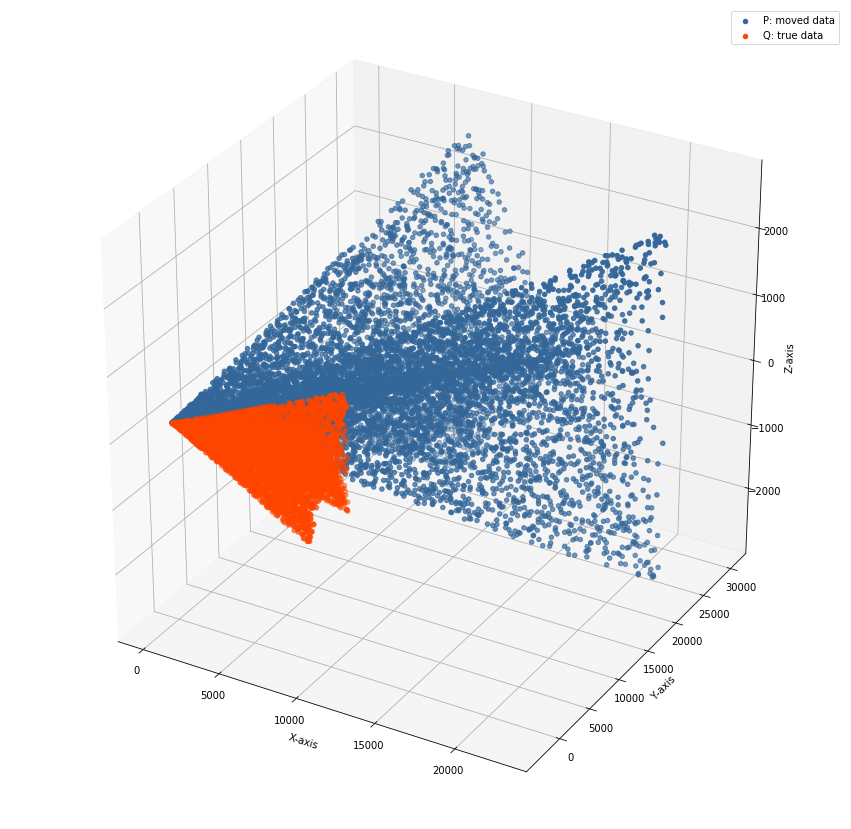

In [195]:
num_points = 10000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = S.dot(R_act.dot(Q)) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Centering

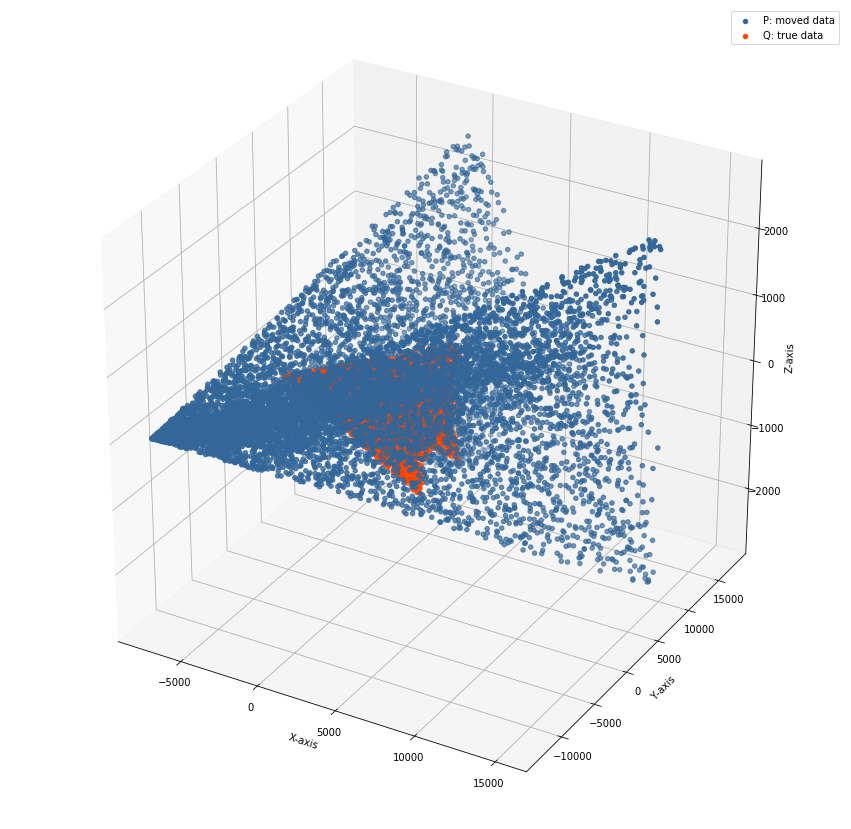

In [196]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### Compute Correspondences

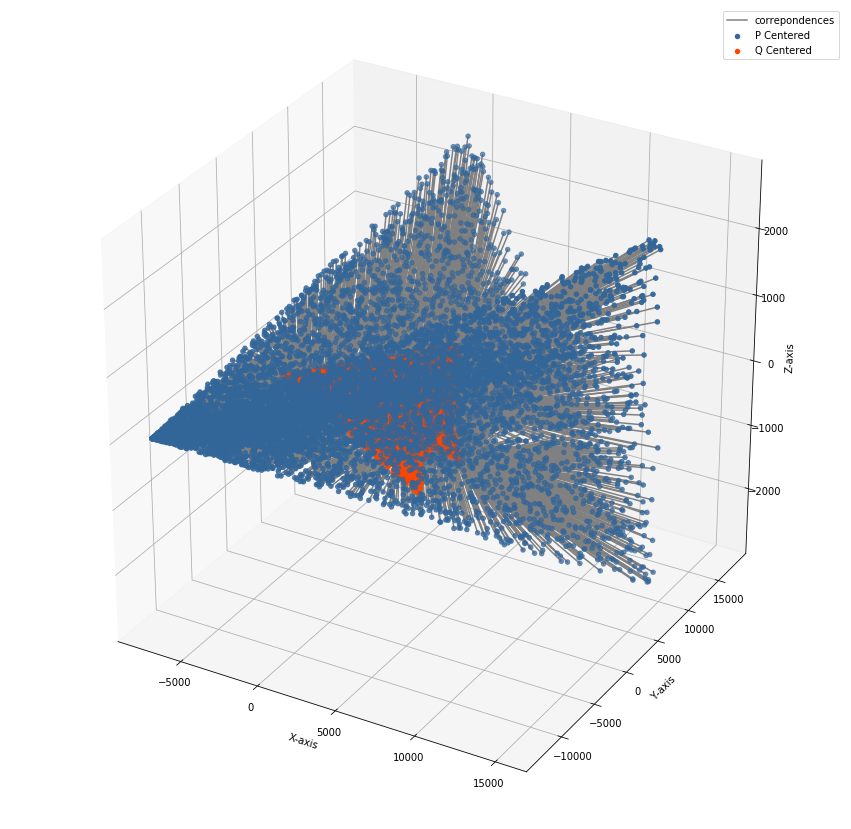

In [197]:
correspondences = kd_tree_correspondences(mean_centered_P, mean_centered_Q)
ax = plot_data(mean_centered_P, mean_centered_Q, label_1='P Centered', label_2='Q Centered')
draw_correspondences(mean_centered_P, mean_centered_Q, correspondences, ax)
plt.show()

#### ICP

Iteration: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


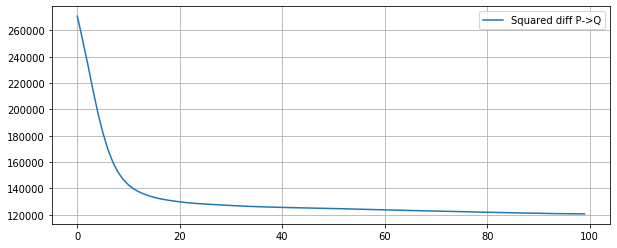

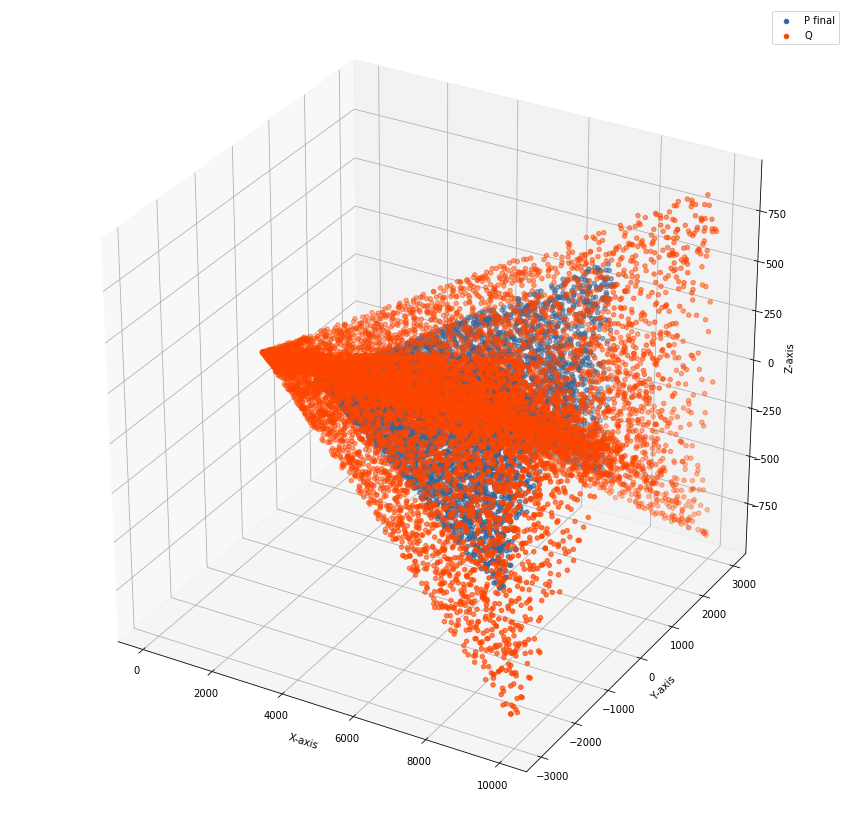

[270711.8473367191, 253368.02133235664, 235038.32736675843, 215701.5713592985, 197574.21638563494, 182054.55469284294, 169255.52008787062, 159321.41064227113, 151972.9312396676, 146546.0969646513, 142555.64907965646, 139626.84805940554, 137442.408004761, 135711.23335031944, 134296.4058679377, 133152.05284335095, 132233.48641362527, 131506.7046256883, 130863.94758343953, 130284.65761518187, 129790.15373083603, 129323.76950318548, 128933.76663161392, 128599.45509611494, 128330.21845371836, 128086.35583449749, 127841.41401590777, 127624.94286842318, 127409.31721791609, 127201.6799789774, 126987.77566136704, 126789.27373568971, 126595.74062108035, 126422.62207695351, 126272.70510974046, 126136.95429722931, 126000.18074139181, 125867.16067586119, 125748.48089781248, 125636.99392576322, 125540.18322725025, 125450.03548936751, 125355.38802656342, 125268.21728244495, 125177.66092145929, 125091.00042493301, 125011.0358314162, 124930.95743383603, 124848.71257306913, 124760.85116938075, 124679.12

In [198]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=100)
# ax = plot_data(P_values, Q, label_1='P final', label_2='Q', markersize_1=15)
p_values , n, c = icp_svd(P_values, Q, iterations=100)
plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)

### 100000 points

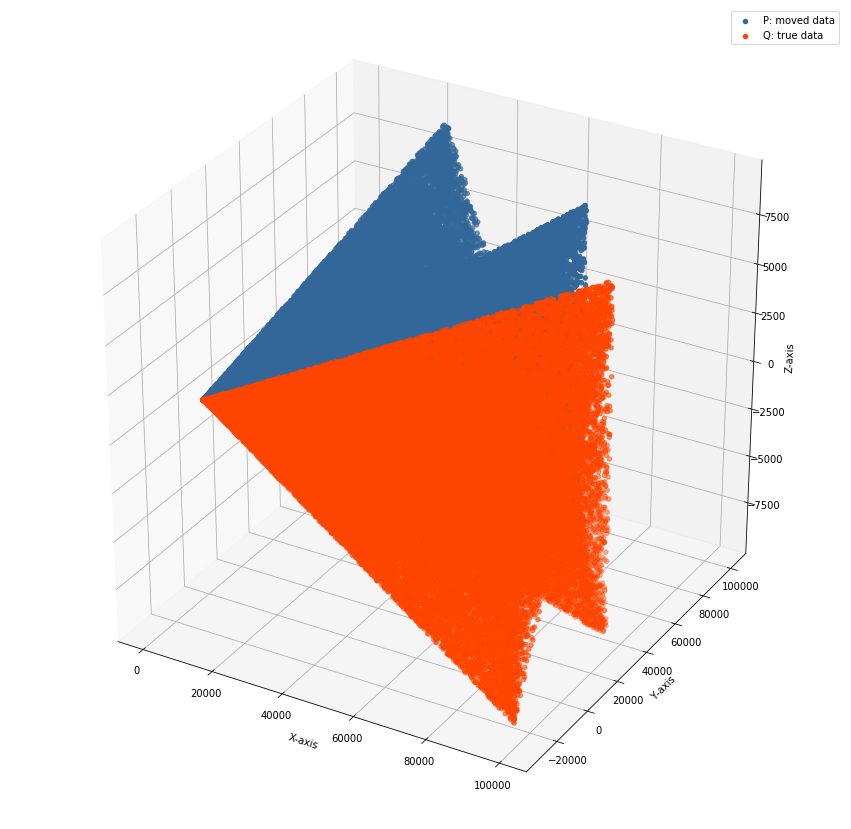

In [199]:
num_points = 100000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Centering

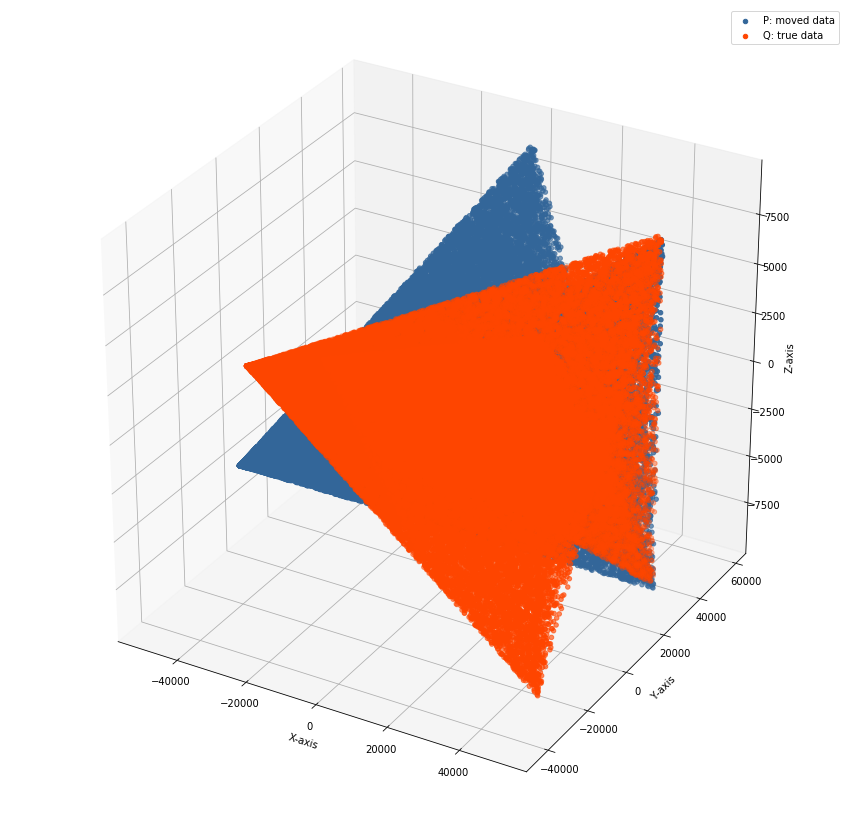

In [200]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### ICP Ran for 10000

In [ ]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=100)
# ax = plot_data(P_values, Q, label_1='P final', label_2='Q', markersize_1=15)
p_values , n, c = icp_svd(P_values, Q, iterations=100)
plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)

Iteration:   8%|▊         | 8/100 [00:51<09:55,  6.48s/it]